In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os #Permite manipular la estructura de directorios
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/PROYECTO DE GRADO/Code


In [ ]:
!pip install plyfile #Libreria para almacenar datos tridimensionales de escáneres 3D. 

In [ ]:
from plyfile import PlyData, PlyElement #Libreria para almacenar datos tridimensionales de escáneres 3D. 
import numpy as np
import cv2 #Librería para problemas de visión por computador
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [ ]:
plydataBunny = PlyData.read('Data/bunny/reconstruction/bun_zipper_res2.ply')

In [ ]:
!ls

 Autoencoders3D.ipynb			   DL.ipynb
 Comparacion.ipynb			   ICPalgorithm.ipynb
'(Copia de Seguridad) Comparacion.ipynb'   Mahalanobis.ipynb
'(Copia Editada) Comparacion.ipynb'	   Prueba1.ipynb
 Data					  'Rotaciones en 3D.ipynb'


In [ ]:
import tarfile 
file = tarfile.open('Data/Armadillo_scans.tar.gz') 
file.extractall('Data/Armadillo') 
file.close()

In [ ]:
import tarfile 
file = tarfile.open('Data/dragon_recon.tar.gz') 
file.extractall('Data/Dragon') 
file.close()

In [ ]:
plydataArmadillo = PlyData.read('Data/Armadillo/Armadillo_scans/Armadillo.ply')

In [ ]:
plydataDragon = PlyData.read('Data/Dragon/dragon_recon/dragon_vrip_res2.ply')

In [ ]:
pointsBunny = []
for point in plydataBunny.elements[0].data:
    pointsBunny.append([point[0], point[1], point[2]])
pointsBunny = np.array(pointsBunny)

In [ ]:
pointsArmadillo = []
for point in plydataArmadillo.elements[0].data:
    pointsArmadillo.append([point[0], point[1], point[2]])
pointsArmadillo = np.array(pointsArmadillo)
pointsArmadillo =(pointsArmadillo)/np.max(pointsArmadillo) #normalizacion de datos armadillo


pointsArmadillo = pointsArmadillo[0:-1:21]

In [ ]:
pointsDragon = []
for point in plydataDragon.elements[0].data:
    pointsDragon.append([point[0], point[1], point[2]])
pointsDragon = np.array(pointsDragon)

pointsDragon = pointsDragon[0:-1:12]

In [ ]:
pointsDragon = pointsDragon-np.mean(pointsDragon,0)
pointsArmadillo = pointsArmadillo-np.mean(pointsArmadillo,0)
pointsBunny = pointsBunny-np.mean(pointsBunny,0)

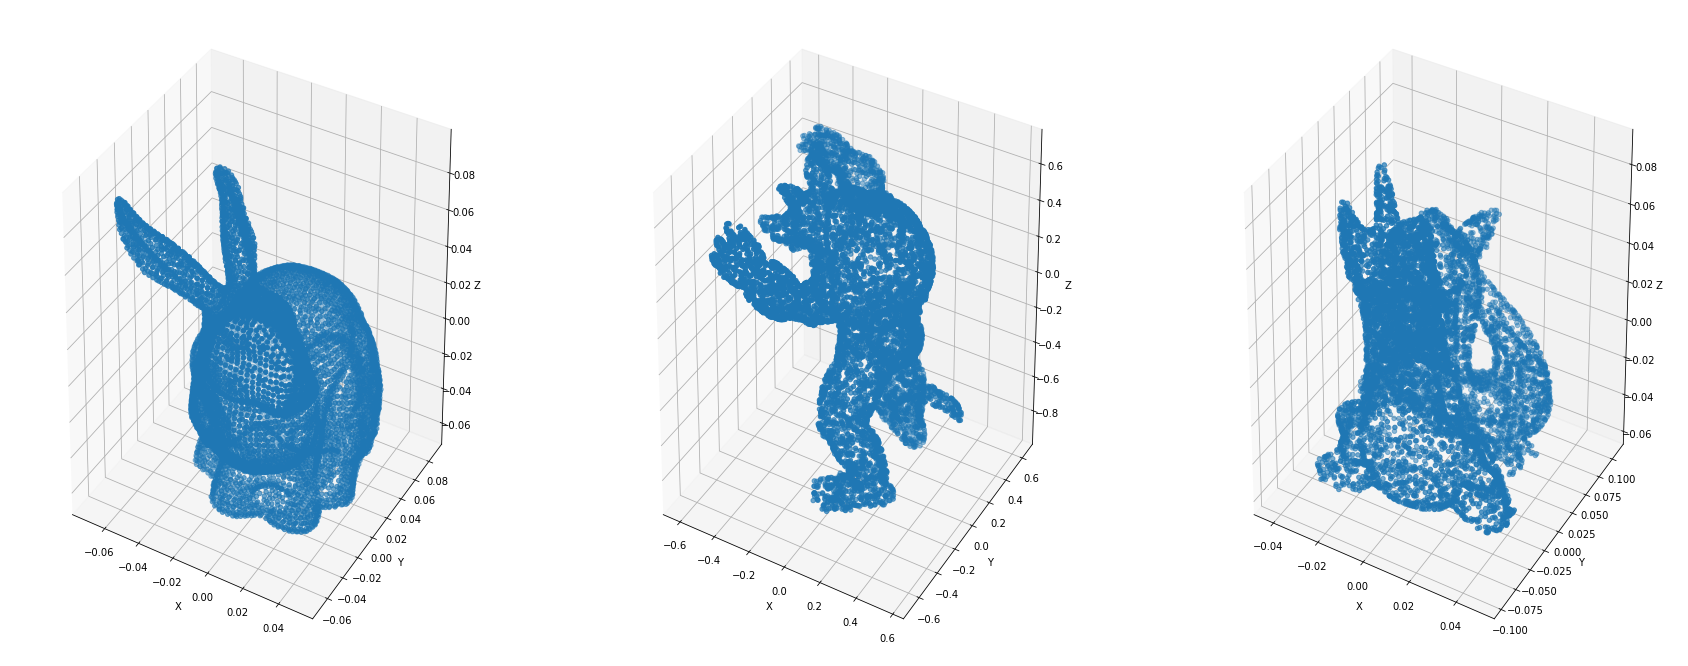

In [ ]:
fig = plt.figure(figsize=(30,12))


ax = fig.add_subplot(1, 3, 1, projection='3d')
X = pointsBunny[:,0]
Y = pointsBunny[:,1]
Z = pointsBunny[:,2]
ax.scatter3D(Z,X,Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


ax = fig.add_subplot(1, 3, 2, projection='3d')
X = pointsArmadillo[:,0]
Y = pointsArmadillo[:,1]
Z = pointsArmadillo[:,2]
ax.scatter3D(Z,-X,Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


ax = fig.add_subplot(1, 3, 3, projection='3d')
X = pointsDragon[:,0]
Y = pointsDragon[:,1]
Z = pointsDragon[:,2]
ax.scatter3D(Z,X,Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
dataset_bunnys = []
dataset_armadillos = []
dataset_dragones = []

for i in range (1000):
  dataset_bunnys.append(pointsBunny+[0.00001*i, 0.0001*i, 0.00001*i])
  dataset_armadillos.append(pointsArmadillo)
  dataset_dragones.append(pointsDragon)

dataset_bunnys = np.array(dataset_bunnys)

In [ ]:

dataset_armadillos = np.array(dataset_armadillos)
dataset_dragones = np.array(dataset_dragones)
print(dataset_bunnys.shape, dataset_armadillos.shape, dataset_dragones.shape)

(1000, 8171, 3) (1000, 8237, 3) (1000, 8355, 3)


In [ ]:
#IGUALANDO CANTIDADES DE PUNTOS PARA PODER CONCATENAR
dataset_armadillos= dataset_armadillos[:,0:8171,:]
dataset_dragones= dataset_dragones[:,0:8171,:]
print(dataset_bunnys.shape, dataset_armadillos.shape, dataset_dragones.shape)

(1000, 8171, 3) (1000, 8171, 3) (1000, 8171, 3)


In [ ]:
dataset = np.concatenate((dataset_bunnys, dataset_armadillos, dataset_dragones))

In [ ]:
dataset.shape

(3000, 8171, 3)

In [ ]:
import tensorflow as tf
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
#Separacion de datos de entrenamiento y test mediante la funcion split, con 20% para test
x_train, x_test = train_test_split(dataset, test_size=0.2)
print(x_train.shape, x_test.shape)

(2400, 8171, 3) (600, 8171, 3)


In [ ]:
x_train = x_train.astype('float32')/np.max(x_train)
x_test = x_test.astype('float32')/ np.max(x_test)
#flatten to put into a DNN autoencoder


(24513,)


In [ ]:
x_train_flatten = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test_flatten = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))
print(x_train_flatten[0].shape)

(15000,)


In [ ]:
input_img = tf.keras.layers.Input(shape=(x_train_flatten[0].shape[0],))
encoded = tf.keras.layers.Dense(256, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(102, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(15000, activation='sigmoid')(decoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 15000)]           0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               3840256   
_________________________________________________________________
dense_17 (Dense)             (None, 102)               26214     
_________________________________________________________________
dense_18 (Dense)             (None, 256)               26368     
_________________________________________________________________
dense_19 (Dense)             (None, 15000)             3855000   
Total params: 7,747,838
Trainable params: 7,747,838
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

hist = autoencoder.fit(x_train_flatten, x_train_flatten, epochs=20, shuffle=True, validation_data=(x_test_flatten, x_test_flatten))

Epoch 1/20
50/50 [==============================] - 5s 86ms/step - loss: 0.6659 - val_loss: 0.6498
Epoch 2/20
50/50 [==============================] - 5s 94ms/step - loss: 0.6044 - val_loss: 0.5493
Epoch 3/20
50/50 [==============================] - 4s 81ms/step - loss: 0.5424 - val_loss: 0.5338
Epoch 4/20
50/50 [==============================] - 4s 82ms/step - loss: 0.5374 - val_loss: 0.5432
Epoch 5/20
50/50 [==============================] - 4s 90ms/step - loss: 0.5383 - val_loss: 0.5414
Epoch 6/20
50/50 [==============================] - 4s 77ms/step - loss: 0.5331 - val_loss: 0.5303
Epoch 7/20
50/50 [==============================] - 4s 78ms/step - loss: 0.5348 - val_loss: 0.5326
Epoch 8/20
50/50 [==============================] - 4s 79ms/step - loss: 0.5340 - val_loss: 0.5506
Epoch 9/20
50/50 [==============================] - 4s 81ms/step - loss: 0.5356 - val_loss: 0.5302
Epoch 10/20
50/50 [==============================] - 4s 82ms/step - loss: 0.5336 - val_loss: 0.5319
Epoch 11/

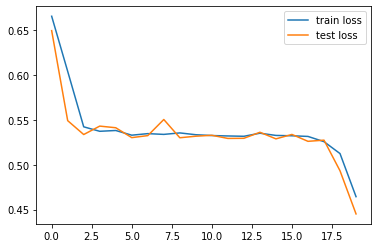

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

In [ ]:
autoencoder.layers[-1]

In [ ]:
encoder = tf.keras.models.Model(input_img, encoded)


#Decoder
#encoded_input = tf.keras.layers.Input(shape=(encoding_dimension,))
#decoder_layer = autoencoder.layers[-2,:]
#decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#print("\n encoder model: encoder \n")
#print(encoder.summary())
#print(" \n decoder model: decoder \n")
#print(decoder.summary())

In [ ]:

encoded_imgs = encoder.predict(x_test_flatten)
predicted = autoencoder.predict(x_test_flatten)
predicted.shape


(400, 15000)

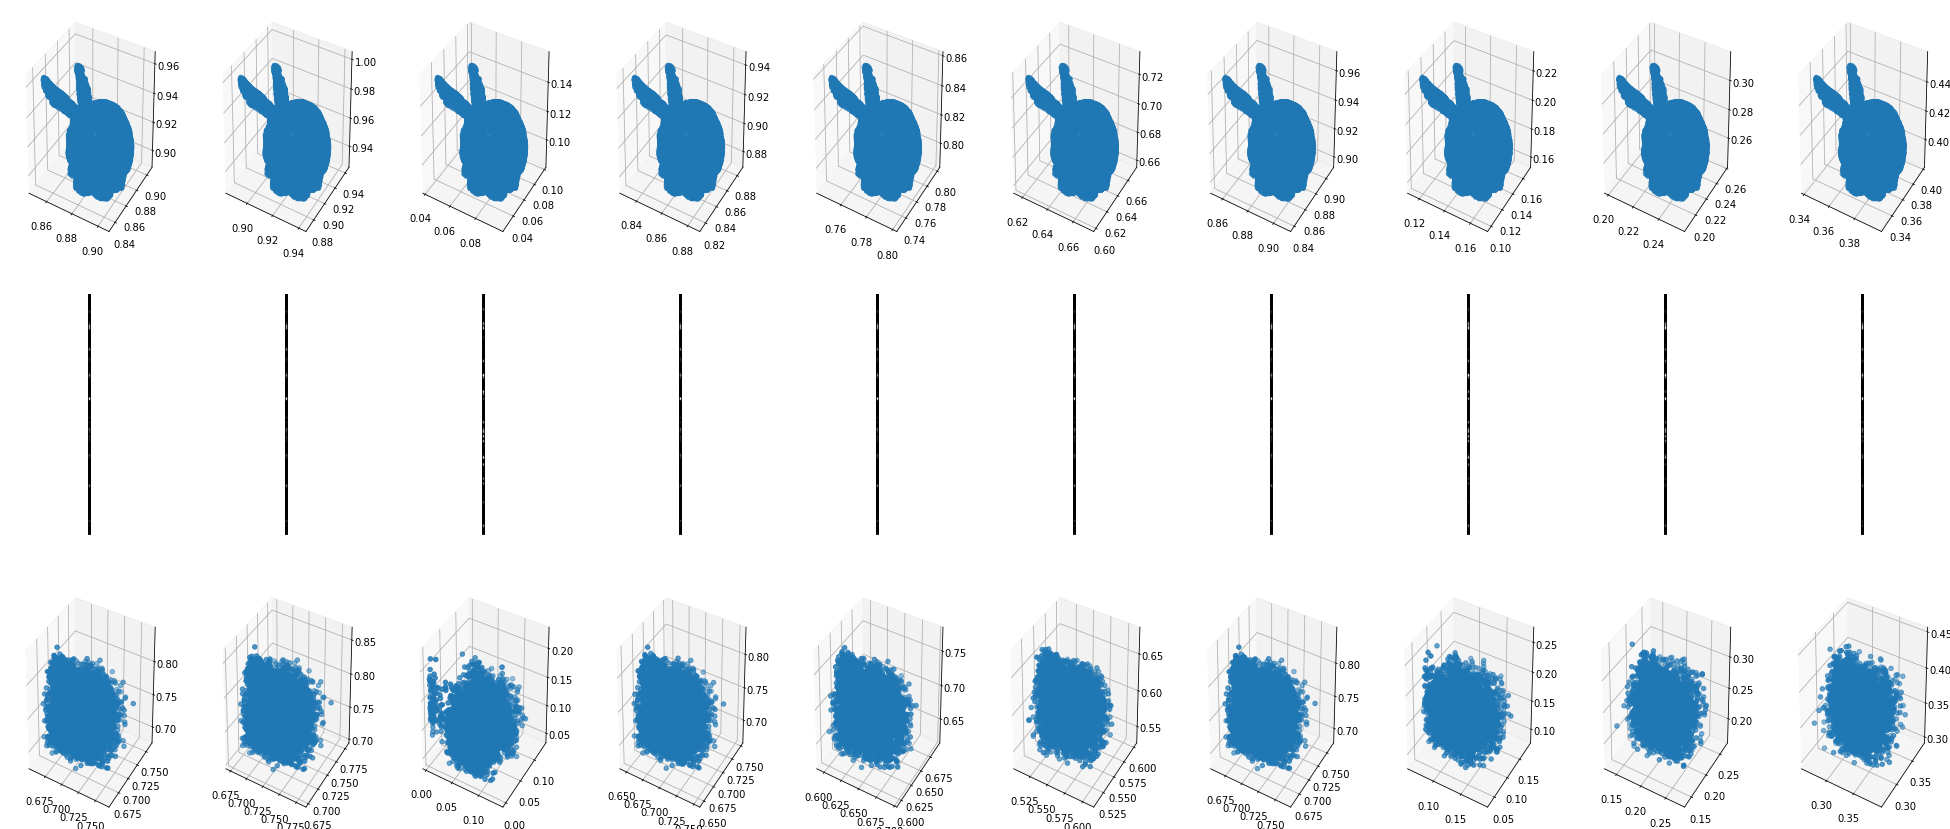

In [ ]:
plt.figure(figsize=(70, 15))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1, projection='3d')
    ax.scatter3D(x_test[i][:,2],x_test[i][:,0],x_test[i][:,1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(102,1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1, projection='3d')
    predictedr = predicted[i].reshape(5000, 3)
   
    ax.scatter3D(predictedr[:,2],predictedr[:,0], predictedr[:,1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
predicted[0]

array([0.6763324 , 0.78487116, 0.6916417 , ..., 0.6892485 , 0.71019936,
       0.7155655 ], dtype=float32)

In [ ]:
x_test_flatten[0]

array([0.85962415, 0.9470875 , 0.8746549 , ..., 0.88144827, 0.8941616 ,
       0.8724425 ], dtype=float32)

#Nuevo Experimento 

In [ ]:
!pip install trimesh

     |████████████████████████████████| 635 kB 7.0 MB/s 


In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
tf.random.set_seed(1234)

In [ ]:
mesh = trimesh.load('Data/bunny/reconstruction/bun_zipper_res2.ply')
mesh.show()

In [ ]:
mesh

<trimesh.Trimesh(vertices.shape=(8146, 3), faces.shape=(16301, 3))>

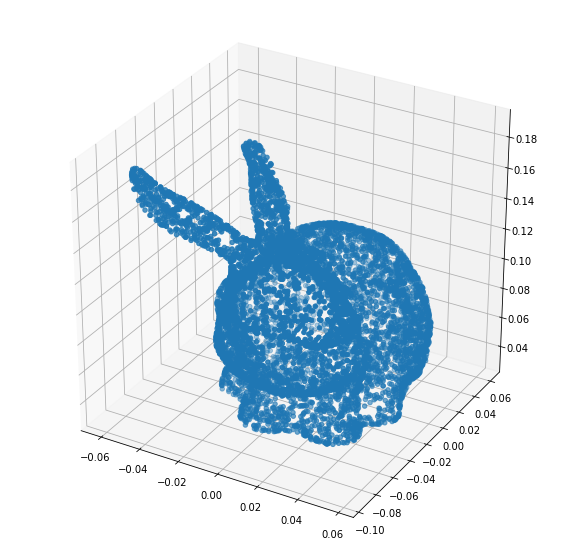

In [ ]:
BunnyPoints = mesh.sample(8100)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter3D(BunnyPoints[:, 2], BunnyPoints[:, 0], BunnyPoints[:, 1])
plt.show()

##Dataset de solo Conejos


In [ ]:
def dataset(num_points, num_samples):
    data_points = []
    mesh1 = trimesh.load('Data/bunny/reconstruction/bun_zipper_res2.ply')
    BunnyPoints = mesh1.sample(num_points)
    mesh2 = trimesh.load('Data/Dragon/dragon_recon/dragon_vrip_res2.ply')
    DragonPoints = mesh2.sample(num_points)
    for i in range (num_samples):
      data_points.append(BunnyPoints+[0.01*(1/(i+1)), 0.01*(1/(i+1)), 0.01*(1/(i+1))])         
      #data_points.append(DragonPoints)
    return np.array(data_points)

In [ ]:
arrayData = dataset(5000,5000)

In [ ]:
arrayData.shape

(5000, 5000, 3)

In [ ]:
x_train, x_test = train_test_split(arrayData, test_size=0.2)
print(x_train.shape, x_test.shape)

(4000, 5000, 3) (1000, 5000, 3)


In [ ]:
x_train = x_train.astype('float32')/np.max(x_train)
x_test = x_test.astype('float32')/ np.max(x_test)


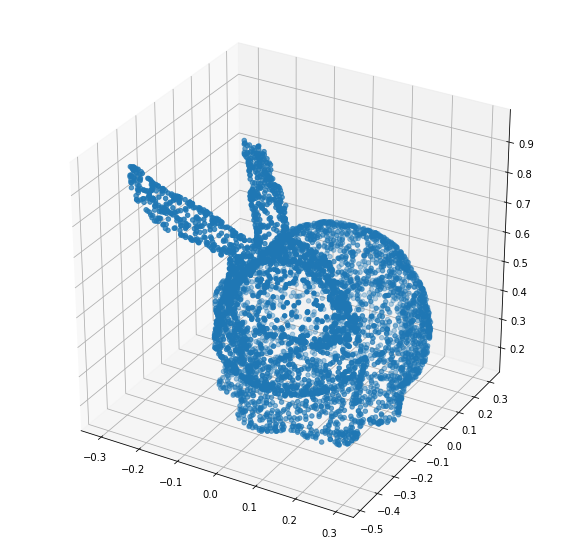

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter3D(x_train[0][:,2], x_train[0][:,0], x_train[0][:,1])
plt.show()

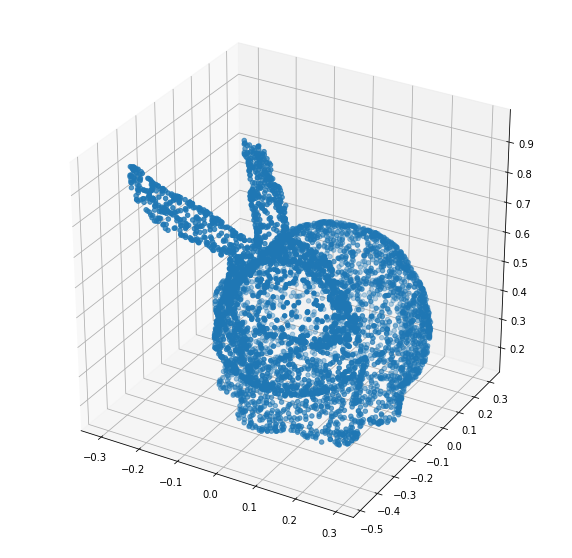

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter3D(x_train[1500][:,2], x_train[1500][:,0], x_train[1500][:,1])
plt.show()

In [ ]:
input_img = tf.keras.layers.Input(shape=x_train.shape[1:])
encoded = tf.keras.layers.Dense(512, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(3, activation='sigmoid')(decoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5000, 3)]         0         
_________________________________________________________________
dense (Dense)                (None, 5000, 512)         2048      
_________________________________________________________________
dense_1 (Dense)              (None, 5000, 256)         131328    
_________________________________________________________________
dense_2 (Dense)              (None, 5000, 128)         32896     
_________________________________________________________________
dense_3 (Dense)              (None, 5000, 64)          8256      
_________________________________________________________________
dense_4 (Dense)              (None, 5000, 32)          2080      
_________________________________________________________________
dense_5 (Dense)              (None, 5000, 64)          2112  

In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.000001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')


hist = autoencoder.fit(x_train, x_train, epochs=20, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
125/125 [==============================] - 21s 144ms/step - loss: 0.6920 - val_loss: 0.6914
Epoch 2/20
125/125 [==============================] - 18s 142ms/step - loss: 0.6907 - val_loss: 0.6898
Epoch 3/20
125/125 [==============================] - 18s 143ms/step - loss: 0.6890 - val_loss: 0.6879
Epoch 4/20
125/125 [==============================] - 18s 145ms/step - loss: 0.6869 - val_loss: 0.6856
Epoch 5/20
125/125 [==============================] - 18s 146ms/step - loss: 0.6844 - val_loss: 0.6827
Epoch 6/20
125/125 [==============================] - 18s 147ms/step - loss: 0.6813 - val_loss: 0.6792
Epoch 7/20
125/125 [==============================] - 18s 148ms/step - loss: 0.6776 - val_loss: 0.6750
Epoch 8/20
125/125 [==============================] - 19s 149ms/step - loss: 0.6731 - val_loss: 0.6700
Epoch 9/20
125/125 [==============================] - 19s 149ms/step - loss: 0.6678 - val_loss: 0.6640
Epoch 10/20
125/125 [==============================] - 19s 150ms/step - l

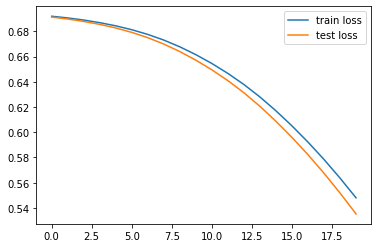

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

In [ ]:
encoder = tf.keras.models.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
predicted = autoencoder.predict(x_test)
predicted.shape

(1000, 5000, 3)

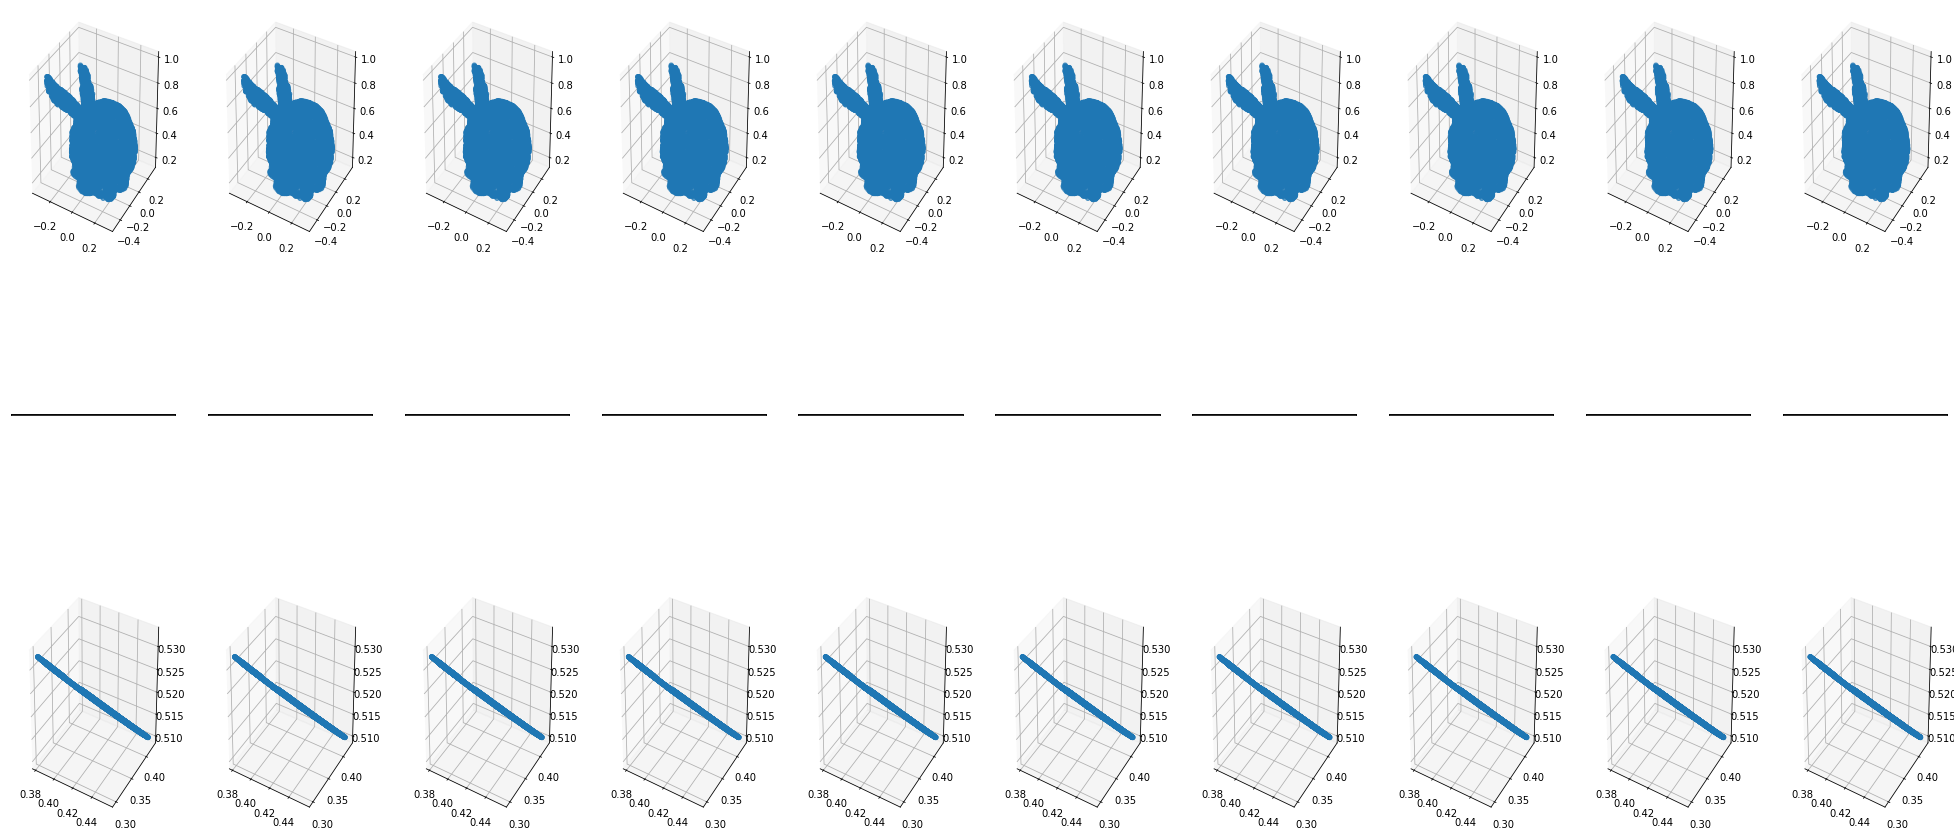

In [ ]:
plt.figure(figsize=(70, 15))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1, projection='3d')
    ax.scatter3D(x_test[i][:,2],x_test[i][:,0],x_test[i][:,1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(32,5000))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1, projection='3d')
    predictedr = predicted[i]
   
    ax.scatter3D(predictedr[:,2],predictedr[:,0], predictedr[:,1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
np.mean((np.abs(predicted[0]-x_test[0])/x_test[0])*100)

-304.12918

In [ ]:
predicted[0]

array([[0.34344012, 0.52395195, 0.40980458],
       [0.34700593, 0.5232365 , 0.412027  ],
       [0.3216419 , 0.52786535, 0.3970774 ],
       ...,
       [0.3815544 , 0.5173047 , 0.43225467],
       [0.3923543 , 0.5152445 , 0.4386538 ],
       [0.38496667, 0.5166463 , 0.43338755]], dtype=float32)

In [ ]:
x_test[0]

array([[-0.16321146,  0.66598314,  0.06541047],
       [-0.30589205,  0.5977459 , -0.0820187 ],
       [-0.40601322,  0.7368589 , -0.02993036],
       ...,
       [ 0.03615662,  0.32393748,  0.28964573],
       [-0.2921469 ,  0.17706902,  0.09485371],
       [-0.02041331,  0.4265963 , -0.19603196]], dtype=float32)

In [ ]:
def X_axis_rotation_matrix(theta):
    return np.array([[1,             0,              0],
                     [0, np.cos(theta), -np.sin(theta)],
                     [0, np.sin(theta),  np.cos(theta)]])

In [ ]:
def Y_axis_rotation_matrix(theta):
    return np.array([[np.cos(theta),  0,  np.sin(theta)],
                     [0,              1,              0],
                     [-np.sin(theta), 0,  np.cos(theta)]])

In [ ]:
def Z_axis_rotation_matrix(theta):
    return np.array([[np.cos(theta),   -np.sin(theta),    0],
                     [np.sin(theta),    np.cos(theta),    0],
                     [0,                0,                1]])

In [ ]:
conejos=[]
angulos = []
for angle_x in np.arange(0,np.pi,0.1): #Cogí pasos de 0.1 radianes porque si no se explota otra vez :(
  for angle_y in np.arange(0,np.pi,0.1):
    for angle_z in np.arange(0,np.pi,0.1):

      conejo_rotado = np.dot(X_axis_rotation_matrix(angle_x),x_test[0].T).T
      conejo_rotado = np.dot(Y_axis_rotation_matrix(angle_y),conejo_rotado.T).T
      conejo_rotado = np.dot(Z_axis_rotation_matrix(angle_z),conejo_rotado.T).T

      conejos.append(conejo_rotado)
      angulos.append([angle_x, angle_y, angle_z])



In [ ]:
conejos=np.array(conejos)

In [ ]:
conejos.shape

(32768, 5000, 3)

In [ ]:
encoder = tf.keras.models.Model(input_img, encoded)
encoded_imgs = encoder.predict(conejos[600:700])
predicted = autoencoder.predict(conejos[600:700])
predicted.shape

(100, 5000, 3)

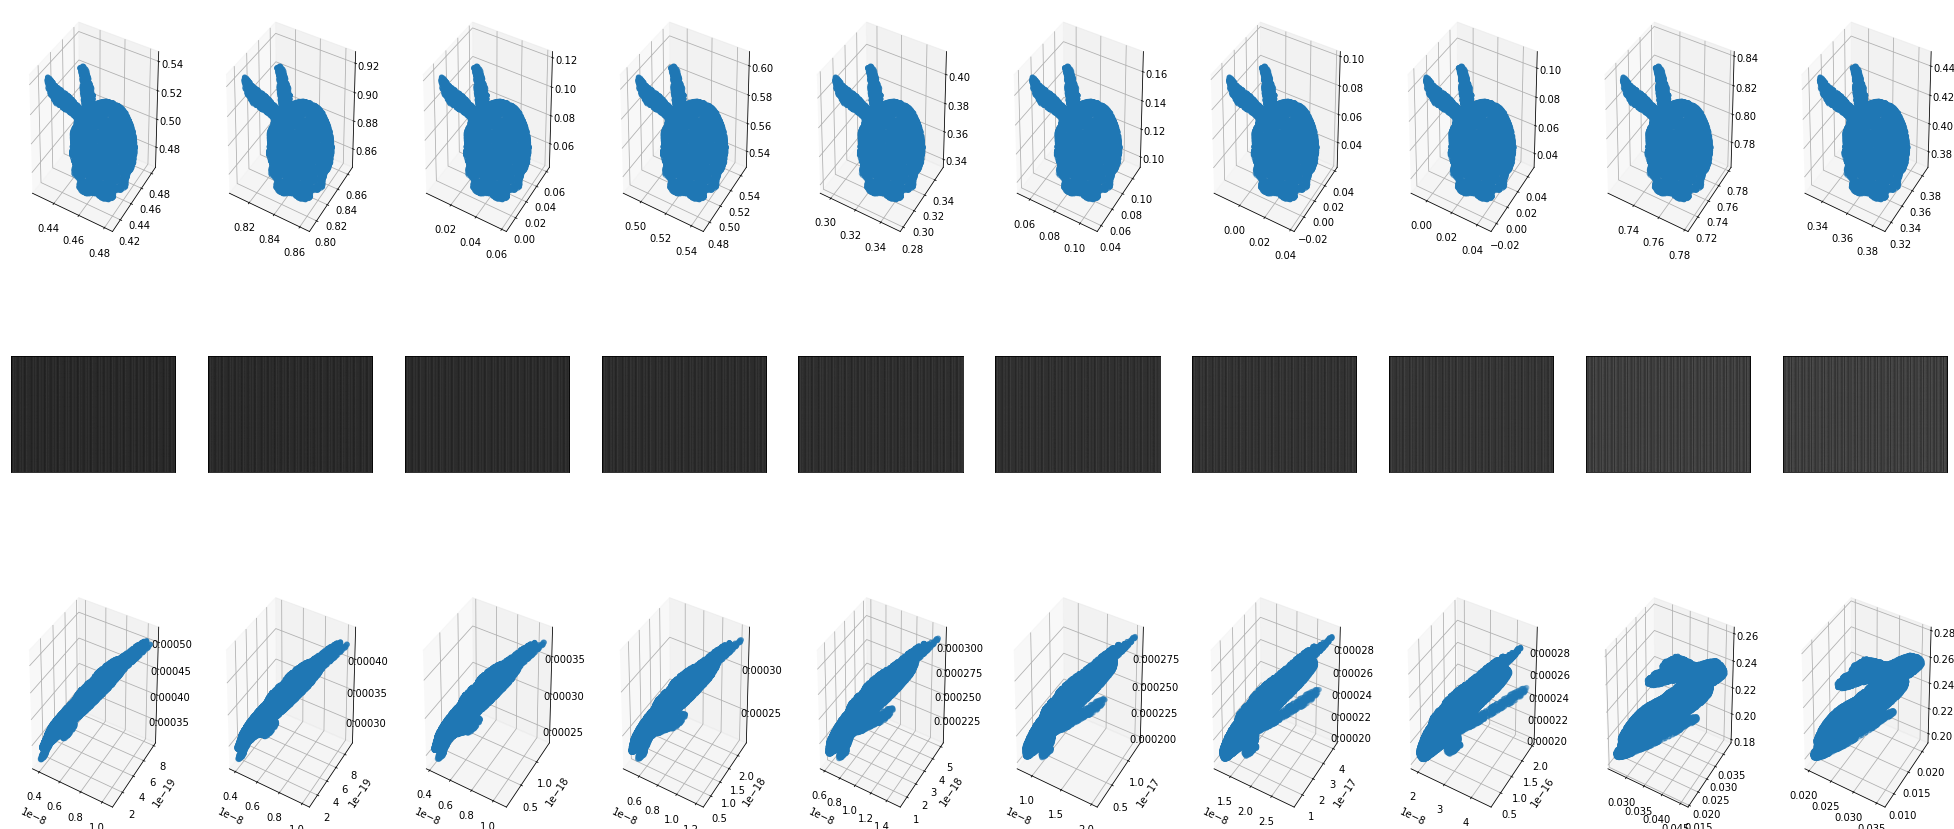

In [ ]:
plt.figure(figsize=(70, 15))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1, projection='3d')
    ax.scatter3D(x_test[i][:,2],x_test[i][:,0],x_test[i][:,1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(600,850))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1, projection='3d')
    predictedr = predicted[i]
   
    ax.scatter3D(predictedr[:,2],predictedr[:,0], predictedr[:,1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
np.mean((np.abs(predicted[0]-x_test[0])/x_test[0])*100)

3.2044506

In [ ]:
predicted[0][0]

array([0.16765551, 0.19433351, 0.16758028], dtype=float32)

In [ ]:
x_test[0][0]

array([0.17139767, 0.19615257, 0.15699376], dtype=float32)

## Con dataset de más animales

In [ ]:
def dataset2(num_points, num_samples):
    data_points = []
    mesh1 = trimesh.load('Data/bunny/reconstruction/bun_zipper_res2.ply')
    BunnyPoints = mesh1.sample(num_points)
    mesh2 = trimesh.load('Data/Dragon/dragon_recon/dragon_vrip_res2.ply')
    DragonPoints = mesh2.sample(num_points)
    mesh3= trimesh.load('Data/Armadillo/Armadillo_scans/Armadillo.ply')
    ArmaPoints = mesh3.sample(num_points)
    for i in range (num_samples):
      data_points.append(BunnyPoints+[0.001*i, 0.001*i, 0.001*i])         
      data_points.append(DragonPoints+[0.001*i, 0.001*i, 0.001*i])    
      
    return np.array(data_points)

In [ ]:
arrayData2 = dataset2(5000,3000)

In [ ]:
arrayData2.shape

(6000, 5000, 3)

In [ ]:
x_train2, x_test2 = train_test_split(arrayData2, test_size=0.2)
print(x_train2.shape, x_test2.shape)

(4800, 5000, 3) (1200, 5000, 3)


In [ ]:
x_train2 = x_train2.astype('float32')/np.max(x_train2)
x_test2 = x_test2.astype('float32')/np.max(x_test2)


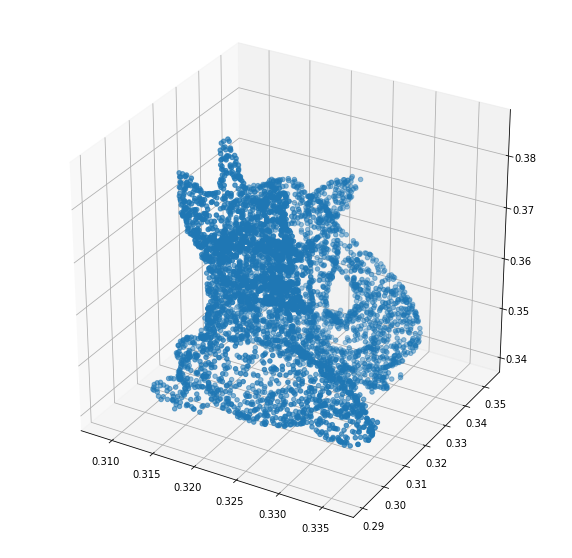

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter3D(x_train2[0][:, 2], x_train2[0][:, 0], x_train2[0][:, 1])
plt.show()

In [ ]:
input_img = tf.keras.layers.Input(shape=x_train2.shape[1:])
encoded = tf.keras.layers.Dense(256, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(102, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(3, activation='sigmoid')(decoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5000, 3)]         0         
_________________________________________________________________
dense_10 (Dense)             (None, 5000, 256)         1024      
_________________________________________________________________
dense_11 (Dense)             (None, 5000, 102)         26214     
_________________________________________________________________
dense_12 (Dense)             (None, 5000, 256)         26368     
_________________________________________________________________
dense_13 (Dense)             (None, 5000, 3)           771       
Total params: 54,377
Trainable params: 54,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')


hist = autoencoder.fit(x_train2, x_train2, epochs=20, shuffle=True, validation_data=(x_test2, x_test2))

Epoch 1/20
50/50 [==============================] - 6s 104ms/step - loss: 0.6161 - val_loss: 0.5636
Epoch 2/20
50/50 [==============================] - 5s 97ms/step - loss: 0.5487 - val_loss: 0.5585
Epoch 3/20
50/50 [==============================] - 5s 96ms/step - loss: 0.5464 - val_loss: 0.5573
Epoch 4/20
50/50 [==============================] - 5s 97ms/step - loss: 0.5454 - val_loss: 0.5569
Epoch 5/20
50/50 [==============================] - 5s 97ms/step - loss: 0.5446 - val_loss: 0.5561
Epoch 6/20
50/50 [==============================] - 5s 97ms/step - loss: 0.5444 - val_loss: 0.5562
Epoch 7/20
50/50 [==============================] - 5s 98ms/step - loss: 0.5439 - val_loss: 0.5557
Epoch 8/20
50/50 [==============================] - 5s 97ms/step - loss: 0.5438 - val_loss: 0.5552
Epoch 9/20
50/50 [==============================] - 5s 98ms/step - loss: 0.5434 - val_loss: 0.5550
Epoch 10/20
50/50 [==============================] - 5s 97ms/step - loss: 0.5430 - val_loss: 0.5546
Epoch 11

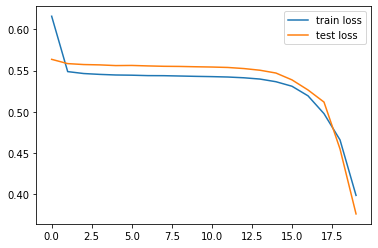

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

In [ ]:
encoder = tf.keras.models.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test2)
predicted = autoencoder.predict(x_test2)
predicted.shape

(400, 5000, 3)

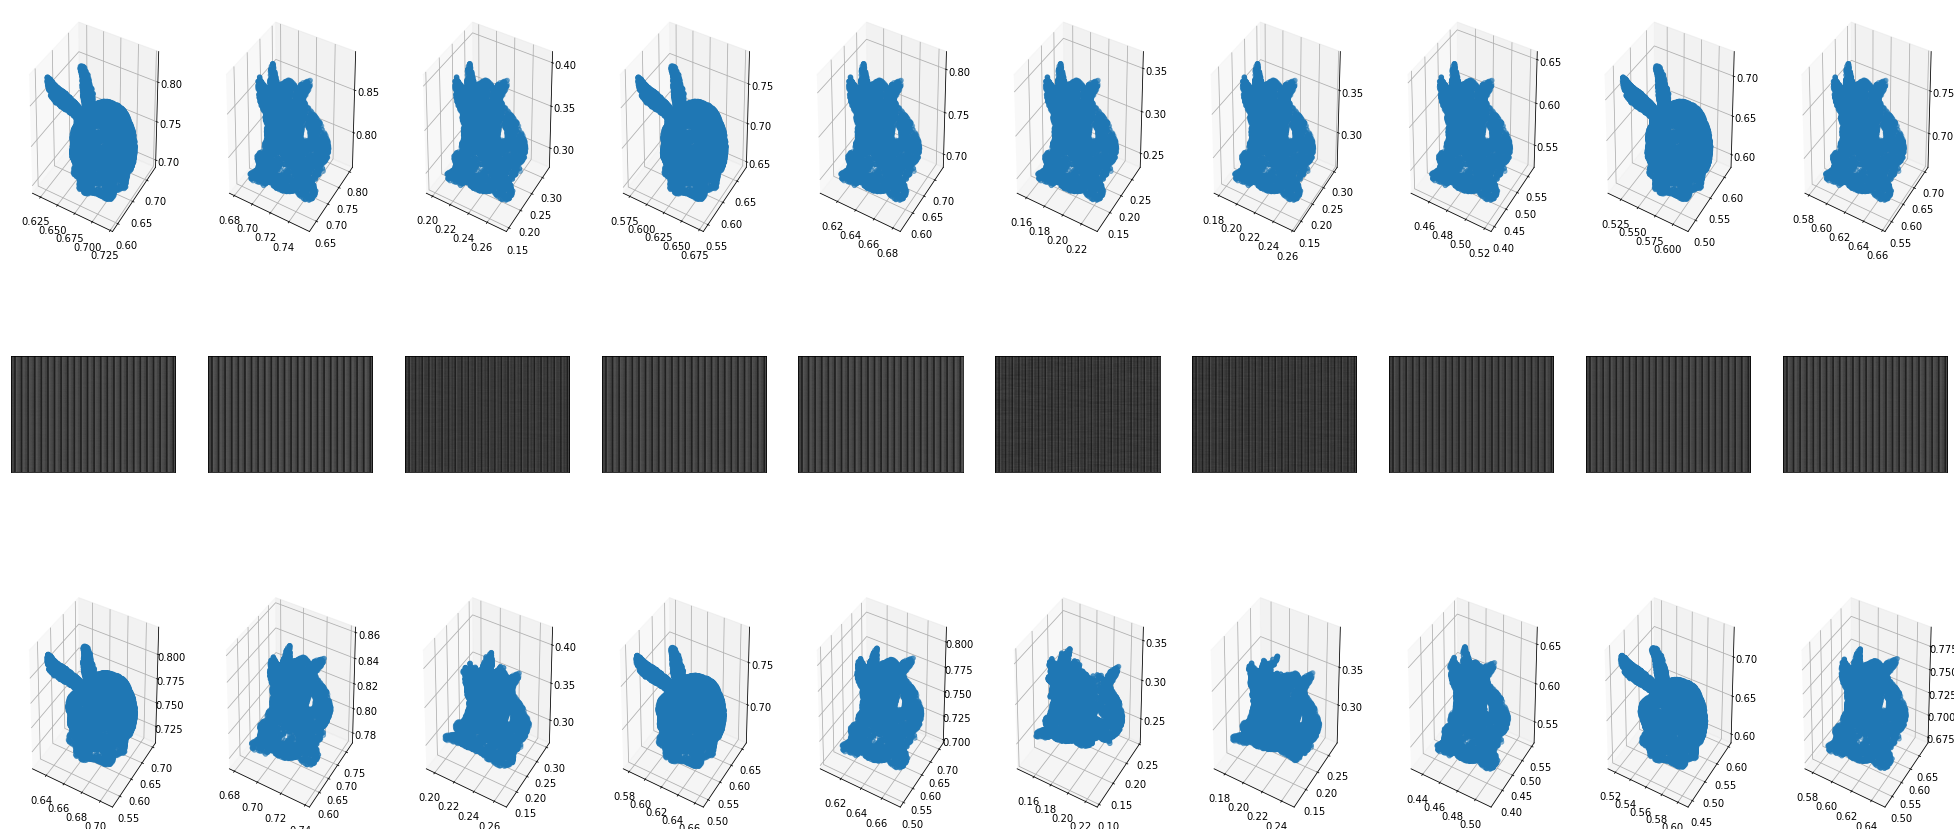

In [ ]:
plt.figure(figsize=(70, 15))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1, projection='3d')
    ax.scatter3D(x_test2[i][:,2],x_test2[i][:,0],x_test2[i][:,1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(600,850))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1, projection='3d')
    predictedr = predicted[i]
    ax.scatter3D(predictedr[:,2],predictedr[:,0], predictedr[:,1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
predicted[4]

array([[0.6763811 , 0.7494792 , 0.632011  ],
       [0.5754116 , 0.72722983, 0.6217722 ],
       [0.5429895 , 0.7870324 , 0.62866616],
       ...,
       [0.6653355 , 0.7540541 , 0.6239468 ],
       [0.5298438 , 0.77340186, 0.6352636 ],
       [0.56650394, 0.75625956, 0.6280225 ]], dtype=float32)

In [ ]:
x_test2[4]

array([[0.6980264 , 0.7402921 , 0.6297994 ],
       [0.6151646 , 0.7158957 , 0.6244852 ],
       [0.5985457 , 0.7846388 , 0.62425846],
       ...,
       [0.6887456 , 0.74739033, 0.61982137],
       [0.58555657, 0.7666816 , 0.6336598 ],
       [0.6130756 , 0.7478714 , 0.6275972 ]], dtype=float32)

y si hago el predict pasandole un conejo rotado y/o transladado?

##Otro Modelo

In [ ]:
input_img = tf.keras.layers.Input(shape=x_train2.shape[1:] ) 
x = tf.keras.layers.Dense(512, activation='relu')(input_img)
x = tf.keras.layers.MaxPooling1D((2),padding='same')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
encoded = tf.keras.layers.MaxPooling1D((2), padding='same')(x) 
x = tf.keras.layers.UpSampling1D((2))(encoded)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.UpSampling1D((2))(x)
decoded = tf.keras.layers.Dense(3, activation='sigmoid')(x)

autoencoder_cnn = tf.keras.models.Model(input_img, decoded)

autoencoder_cnn.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 5000, 3)]         0         
_________________________________________________________________
dense_157 (Dense)            (None, 5000, 512)         2048      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 2500, 512)         0         
_________________________________________________________________
dense_158 (Dense)            (None, 2500, 256)         131328    
_________________________________________________________________
dense_159 (Dense)            (None, 2500, 128)         32896     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 1250, 128)         0         
_________________________________________________________________
up_sampling1d_38 (UpSampling (None, 2500, 128)         0  

In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.001)
autoencoder_cnn.compile(optimizer=opt, loss='binary_crossentropy')


hist = autoencoder_cnn.fit(x_train2, x_train2, epochs=20, shuffle=True, validation_data=(x_test2, x_test2))

Epoch 1/20
150/150 [==============================] - 37s 133ms/step - loss: 0.5468 - val_loss: 0.5226
Epoch 2/20
150/150 [==============================] - 19s 128ms/step - loss: 0.5254 - val_loss: 0.5225
Epoch 3/20
150/150 [==============================] - 19s 128ms/step - loss: 0.5251 - val_loss: 0.5222
Epoch 4/20
150/150 [==============================] - 19s 128ms/step - loss: 0.5251 - val_loss: 0.5223
Epoch 5/20
150/150 [==============================] - 19s 129ms/step - loss: 0.5250 - val_loss: 0.5222
Epoch 6/20
150/150 [==============================] - 19s 129ms/step - loss: 0.5250 - val_loss: 0.5222
Epoch 7/20
150/150 [==============================] - 19s 129ms/step - loss: 0.5249 - val_loss: 0.5220
Epoch 8/20
150/150 [==============================] - 19s 129ms/step - loss: 0.5249 - val_loss: 0.5220
Epoch 9/20
150/150 [==============================] - 19s 130ms/step - loss: 0.5247 - val_loss: 0.5216
Epoch 10/20
150/150 [==============================] - 19s 129ms/step - l

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

In [ ]:
encoder = tf.keras.models.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test2)
predicted = autoencoder_cnn.predict(x_test2)
predicted.shape

(1200, 5000, 3)

In [ ]:
plt.figure(figsize=(70, 15))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1, projection='3d')
    ax.scatter3D(x_test2[i][:,2],x_test2[i][:,0],x_test2[i][:,1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(128, 1250))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1, projection='3d')
    predictedr = predicted[i]
   
    ax.scatter3D(predictedr[:,2],predictedr[:,0], predictedr[:,1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
predicted[4]

array([[0.13959637, 0.14762305, 0.1364333 ],
       [0.13959637, 0.14762305, 0.1364333 ],
       [0.13959637, 0.14762305, 0.1364333 ],
       ...,
       [0.1400855 , 0.14806221, 0.13684382],
       [0.1400855 , 0.14806221, 0.13684382],
       [0.1400855 , 0.14806221, 0.13684382]], dtype=float32)

In [ ]:
x_test2[4]

array([[0.00869215, 0.06166283, 0.00803677],
       [0.02160404, 0.04617245, 0.00787289],
       [0.00044845, 0.06780935, 0.01603188],
       ...,
       [0.01680717, 0.06154583, 0.01212658],
       [0.02844159, 0.03921816, 0.01745056],
       [0.02745388, 0.0352693 , 0.01432141]], dtype=float32)

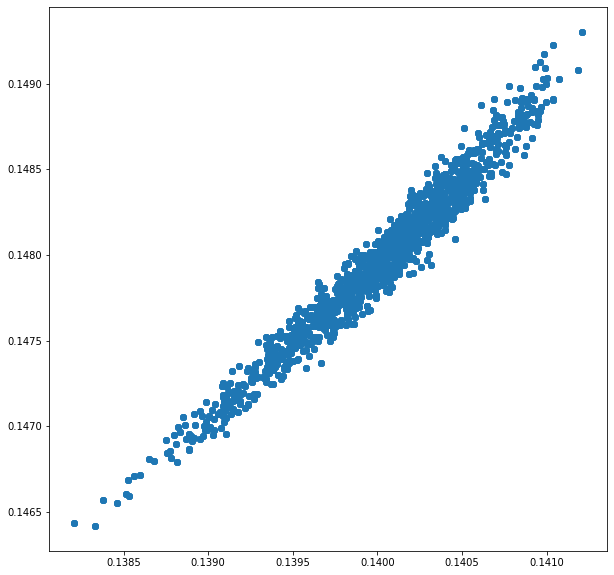

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(predicted[4][:,0], predicted[4][:,1])
plt.show()

In [ ]:
x_train2.shape

(4800, 5000, 3)

##Probando reconstruccion en 2D

In [ ]:
def dataset(num_points, num_samples):
    data_points = []
    mesh1 = trimesh.load('Data/bunny/reconstruction/bun_zipper_res2.ply')
    BunnyPoints = mesh1.sample(num_points)
    mesh2 = trimesh.load('Data/Dragon/dragon_recon/dragon_vrip_res2.ply')
    DragonPoints = mesh2.sample(num_points)
    for i in range (num_samples):
      data_points.append(BunnyPoints+[0.001*i, 0.001*i, 0.001*i])         
      #data_points.append(DragonPoints)
    return np.array(data_points)

In [ ]:
arrayData = dataset(5000,2000)

In [ ]:
arrayData.shape

(2000, 5000, 3)

In [ ]:
x_train, x_test = train_test_split(arrayData, test_size=0.2)
print(x_train.shape, x_test.shape)

(1600, 5000, 3) (400, 5000, 3)


In [ ]:
x_train = x_train.astype('float32')/np.max(x_train)
x_test = x_test.astype('float32')/ np.max(x_test)


In [ ]:
x_train = x_train[:,:,:2]
x_train.shape

(1600, 5000, 2)

In [ ]:
x_test = x_test[:,:,:2]
x_test.shape

(400, 5000, 2)

In [ ]:
x_test=x_test.reshape(400,10000)
x_train=x_train.reshape(1600,10000)

In [ ]:
input_img = tf.keras.layers.Input(shape=x_train.shape[1:])
encoded = tf.keras.layers.Dense(256, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(102, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(10000, activation='sigmoid')(decoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dense_25 (Dense)             (None, 102)               26214     
_________________________________________________________________
dense_26 (Dense)             (None, 256)               26368     
_________________________________________________________________
dense_27 (Dense)             (None, 10000)             2570000   
Total params: 5,182,838
Trainable params: 5,182,838
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')


hist = autoencoder.fit(x_train, x_train, epochs=20, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
50/50 [==============================] - 1s 12ms/step - loss: 0.6628 - val_loss: 0.6272
Epoch 2/20
50/50 [==============================] - 0s 9ms/step - loss: 0.5767 - val_loss: 0.5460
Epoch 3/20
50/50 [==============================] - 0s 8ms/step - loss: 0.5351 - val_loss: 0.5423
Epoch 4/20
50/50 [==============================] - 0s 8ms/step - loss: 0.5311 - val_loss: 0.5407
Epoch 5/20
50/50 [==============================] - 0s 9ms/step - loss: 0.5314 - val_loss: 0.5406
Epoch 6/20
50/50 [==============================] - 0s 9ms/step - loss: 0.5324 - val_loss: 0.5419
Epoch 7/20
50/50 [==============================] - 0s 9ms/step - loss: 0.5295 - val_loss: 0.5402
Epoch 8/20
50/50 [==============================] - 0s 9ms/step - loss: 0.5298 - val_loss: 0.5408
Epoch 9/20
50/50 [==============================] - 0s 9ms/step - loss: 0.5297 - val_loss: 0.5404
Epoch 10/20
50/50 [==============================] - 0s 9ms/step - loss: 0.5323 - val_loss: 0.5490
Epoch 11/20
50/50 

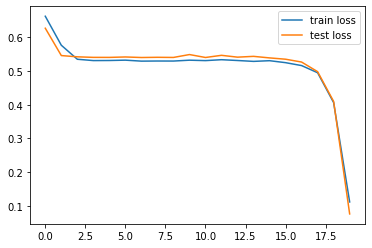

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

In [ ]:
encoder = tf.keras.models.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
predicted = autoencoder.predict(x_test)
predicted.shape

(400, 10000)

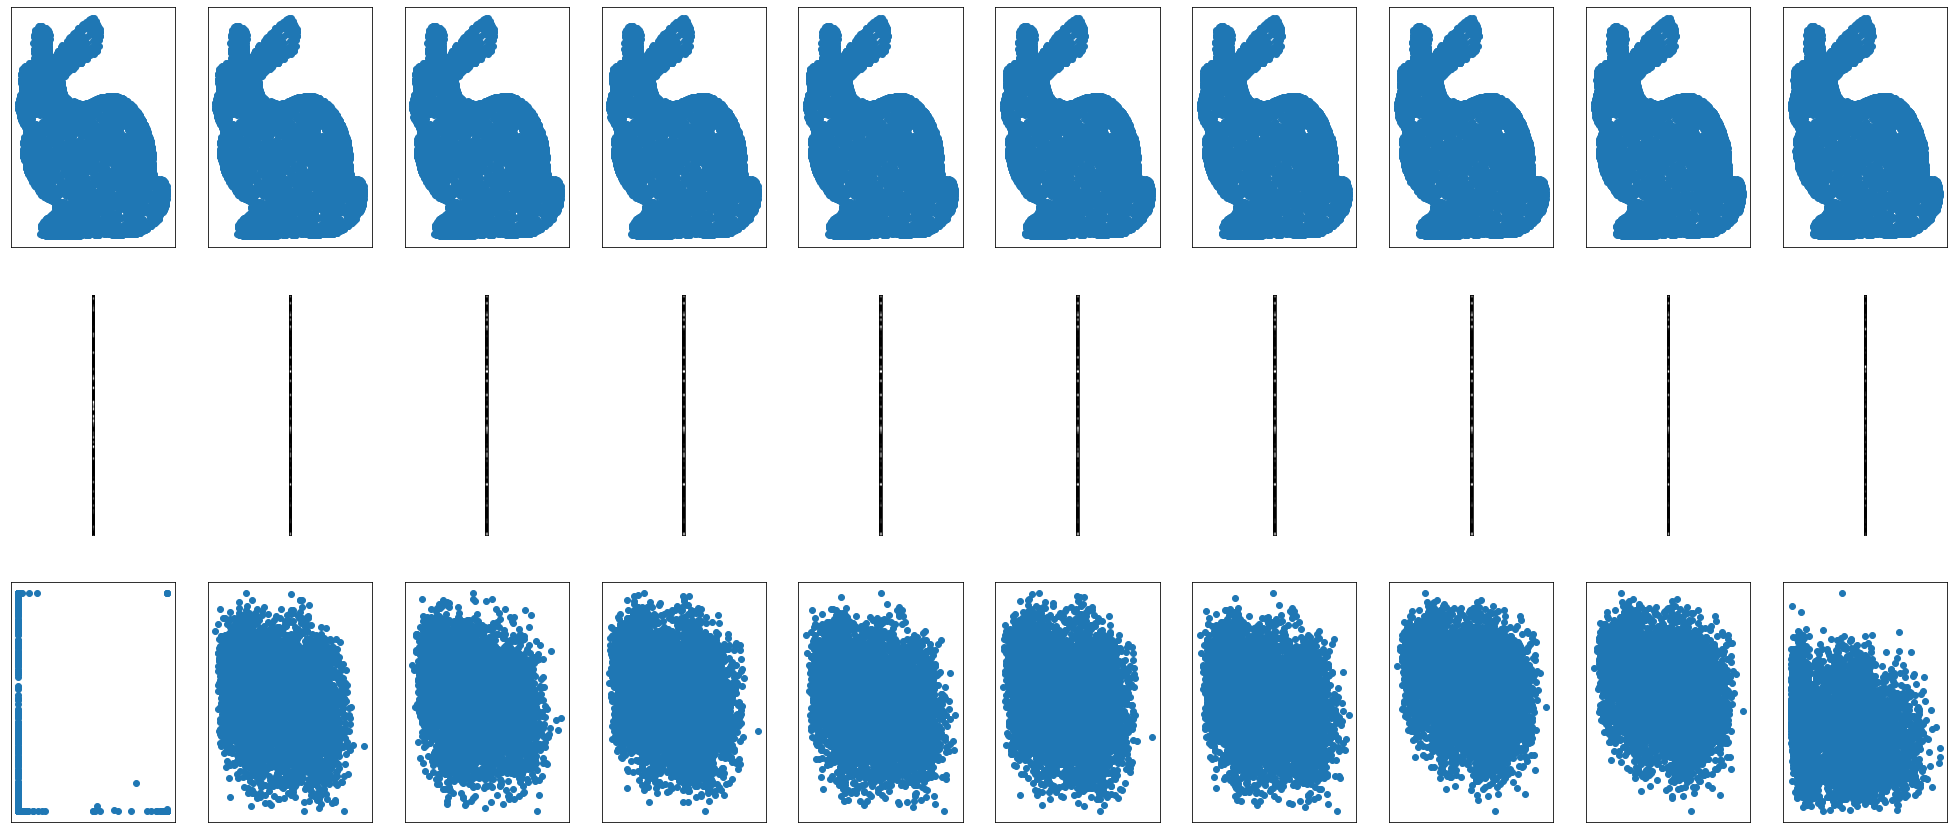

In [ ]:
plt.figure(figsize=(70, 15))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    x_test = x_test.reshape(400, 5000,2)
    ax.scatter(x_test[i][:,0],x_test[i][:,1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(102,1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    predictedr = predicted[i]
    predictedr = predictedr.reshape(5000,2)
    ax.scatter(predictedr[:,0],predictedr[:,1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)